### This notebook contains the recalculation of a 4 * 4 lattice by the numerical method and the Monte Carlo method.

In [ ]:
try: 
  from mc_lib.rndm import RndmWrapper
except ImportError:
  !pip install git+https://github.com/ev-br/mc_lib.git@master
  pass

In [ ]:
try: 
  from _common import tabulate_neighbors
except ImportError:
  from google.colab import files
  uploaded = files.upload()
  pass

Saving _common.py to _common.py
Saving _square.py to _square.py


In [ ]:
%load_ext cython

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### Сorrected algorithm

In [ ]:
# MY ISING
%%cython --cplus
import cython
import numpy as np
cimport numpy as np
from libc.time cimport time
from libc.math cimport exp
from mc_lib.rndm cimport RndmWrapper
from _common import tabulate_neighbors
from mc_lib.observable cimport RealObservable

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray initState(int linear_size, RndmWrapper rndm):
    cdef np.ndarray[np.int_t, ndim=2,negative_indices=False,
                    mode='c'] lattice = np.zeros([linear_size, linear_size], dtype=int)
    cdef int i
    cdef int j
    for i in range(linear_size):
        for j in range(linear_size):
            lattice[i,j] = 1 if rndm.uniform() > 0.5 else -1
    return lattice

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray mcmove(np.ndarray config,double beta,int L,
                    np.ndarray [np.int_t, ndim=2,negative_indices=False] ngb,
                     RndmWrapper rndm):
    """
    One Monte-Carlo step

    params:
        config: Current configuration of lattice
        beta:   Inversed temperature of current configuration
        L:      Linear size 'L' of lattice
        ngb:    Array of neigbours
    return:
    """
    cdef:
    # Choose a random spin
        double foo = rndm.uniform()
        int i = int(foo*(L*L)) //L
        int j = int(foo*(L*L)) %L
        # current spin: sigma_i
        int site =  config[i, j]
        #  count neighbours: up, down, left, right
        #  nb = sum( sigma_j )
        double dE = 0
    for n in range(1,5):
        dE += site * config[ngb[i*L + j, n] //L, ngb[i*L + j, n] % L]
    cdef double ratio = exp(-2 * dE * beta)
    if rndm.uniform() > ratio:
      config[i, j] = site
    else:
      site *= -1
      config[i, j] = site
    return
    


@cython.boundscheck(False)  # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire functio
cdef double calcEnergy(np.ndarray config, int L, ngb):
    # config = lattice configuration on current step
    # L - size of lattice
    cdef:
        int i
        int j
        int site
        # int nb
        double energy = 0
    for i in range(L):
        for j in range(L):
            site = config[i, j]
            # nb = 0
            for n in range(1,5):
              one_ngb = config[ngb[i*L + j, n] //L, ngb[i*L + j, n] % L]
              energy += -1 * site * one_ngb
    return energy / 4.


@cython.boundscheck(False)  # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def IsingSimulate_new(L, T, sweeps, int seed, int rseed = 1234):
    """
        L - linear_size
        T - One temperature point
        Sweeps - number of L^2 Metropolis Monte-Karlo steps

    """
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed))
    cdef RealObservable e = RealObservable()
    cdef:
        float beta = 1.0 / T  # inversed temperature
        int sweep = 0
        int steps_per_sweep = L * L
        int num_therm = int(30 * L) # ?10?
        int i


    cdef:
        list configs = []
        np.ndarray [np.int_t, ndim=2,negative_indices=False] ngb =\
         tabulate_neighbors(L, kind='sq')
        np.ndarray[np.int_t, ndim = 2, negative_indices = False, mode = 'c'] config
    config = initState(L, rndm)
    configs.append(config.copy())
    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            mcmove(config, beta, L, ngb, rndm)
    enes = np.zeros(sweeps)

    for sweep in range(sweeps):
        for i in range(steps_per_sweep):
            mcmove(config, beta, L, ngb, rndm)

        Et = calcEnergy(config, L, ngb)
        e.add_measurement(Et)
        enes[sweep] = Et

    error = e.errorbar
    mean_energ = e.mean
    converg = e.is_converged
    return enes, mean_energ, error,converg, configs



### Old algorithm
contain an error with declaration "Energy" in calcEnergy function 

In [ ]:
# MY ISING_old
%%cython --cplus
import cython
import numpy as np
cimport numpy as np
from libc.time cimport time
from libc.math cimport exp
from mc_lib.rndm cimport RndmWrapper
from _common import tabulate_neighbors
from mc_lib.observable cimport RealObservable

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray initState(int linear_size, RndmWrapper rndm):
    cdef np.ndarray[np.int_t, ndim=2,negative_indices=False,
                    mode='c'] lattice = np.zeros([linear_size, linear_size], dtype=int)
    cdef int i
    cdef int j
    for i in range(linear_size):
        for j in range(linear_size):
            lattice[i,j] = 1 if rndm.uniform() > 0.5 else -1
    return lattice

@cython.boundscheck(False)
@cython.wraparound(False)
cdef np.ndarray mcmove22(np.ndarray config,double beta,int L,
                    np.ndarray [np.int_t, ndim=2,negative_indices=False] ngb,
                     RndmWrapper rndm):
    """
    One Monte-Carlo step

    params:
        config: Current configuration of lattice
        beta:   Inversed temperature of current configuration
        L:      Linear size 'L' of lattice
        ngb:    Array of neigbours
    return:
    """
    cdef:
    # Choose a random spin
        int i = int(rndm.uniform()*L)
        int j = int(rndm.uniform()*L)
        # current spin: sigma_i
        int site =  config[i, j]
        #  count neighbours: up, down, left, right
        #  nb = sum( sigma_j )
        double dE = 0
    for n in range(1,5):
        dE += site * config[ngb[i*L + j, n] //L, ngb[i*L + j, n] % L]
    cdef double ratio = exp(-2. * dE * beta)
    if rndm.uniform() > ratio:
      config[i, j] = site
    else:
      site *= -1
      config[i, j] = site
    return
    


@cython.boundscheck(False)  # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire functio
cdef double calcEnergy(np.ndarray config, int L, ngb):
    # config = lattice configuration on current step
    # L - size of lattice
    cdef:
        int i
        int j
        int site
        # int nb
        double energy
    for i in range(L):
        for j in range(L):
            site = config[i, j]
            # nb = 0
            for n in range(1,5):
              one_ngb = config[ngb[i*L + j, n] //L, ngb[i*L + j, n] % L]
              energy += -1 * site * one_ngb
    return energy / 4.


@cython.boundscheck(False)  # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def IsingSimulate_old(L, T, sweeps, int seed, int rseed = 1234):
    """
        L - linear_size
        T - One temperature point
        Sweeps - number of L^2 Metropolis Monte-Karlo steps

    """
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed))
    cdef RealObservable e = RealObservable()
    cdef:
        float beta = 1.0 / T  # inversed temperature
        int sweep = 0
        int steps_per_sweep = L * L
        int num_therm = int(30 * L) # ?10?
        int i


    cdef:
        list configs = []
        np.ndarray [np.int_t, ndim=2,negative_indices=False] ngb =\
         tabulate_neighbors(L, kind='sq')
        np.ndarray[np.int_t, ndim = 2, negative_indices = False, mode = 'c'] config
    config = initState(L, rndm)
    configs.append(config.copy())
    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            mcmove22(config, beta, L, ngb, rndm)
    enes = np.zeros(sweeps)

    for sweep in range(sweeps):
        for i in range(steps_per_sweep):
            mcmove22(config, beta, L, ngb, rndm)

        Et = calcEnergy(config, L, ngb)
        e.add_measurement(Et)
        enes[sweep] = Et

    error = e.errorbar
    mean_energ = e.mean
    converg = e.is_converged
    return enes, mean_energ, error,converg, configs



### Energy recalculation over all lattice states

In [ ]:
%%cython --cplus
cimport cython
import numpy as np
cimport numpy as np
from mc_lib.rndm cimport RndmWrapper
from _common import tabulate_neighbors
from mc_lib.observable cimport RealObservable

@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins,
                             long[:, ::1] neighbors):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * spins[site] * spins[site1]

    return ene / 2.0


def det_energies(int L = 4): # возвращает энергии для всех возможных конфигураций системы 4х4
    
    cdef long[:, ::1] neighbors = tabulate_neighbors(L, kind='sq')
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    
    A = [-1,1]
    conf = [(a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16) for a1 in A for a2 in A for a3 in A for a4 in A for a5 in A for a6 in A for a7 in A for a8 in A for a9 in A for a10 in A for a11 in A for a12 in A for a13 in A for a14 in A for a15 in A for a16 in A]
    cdef long[:,::1] configs = np.asarray(conf) # перебор всех конфигураций
    
    energies = []
    magns = []
    cdef int i
    for i in range(2**16):
        energies.append(energy(configs[i], neighbors))
        magns.append((np.sum(configs[i]))**2)
        
    
        
    return (np.asarray(energies),np.asarray( magns))

### A converted version of the generator from Mc_lib "Frustrated ising"

In [ ]:
# FROM MC_LIB Examples
%%cython --cplus

cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from _common import tabulate_neighbors
from mc_lib.observable cimport RealObservable


cdef void init_spins(np.ndarray[np.int_t, ndim = 1, negative_indices = False, mode = 'c'] spins, RndmWrapper rndm): 
    for j in range(spins.shape[0]):
      spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * spins[site] * spins[site1] 
    
    return ene / 4.0


@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    RndmWrapper rndm): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
        

def simulate_ising(Py_ssize_t L,
             double T,
             Py_ssize_t num_sweeps, int seed, int rseed = 1234):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='sq')
        double beta = 1./T

    cdef:
        list configs = []
        int num_therm = int(30 * L)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i
        
    
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed)) 
    cdef RealObservable e = RealObservable()

    cdef np.ndarray[np.int_t, ndim = 1, negative_indices = False, mode = 'c']  spins =  np.empty( L*L, dtype=int)
    init_spins(spins, rndm)
    configs.append(spins.copy())
    

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, rndm)
    enes = np.zeros(num_sweeps)

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, rndm)
            
        Et = energy(spins, neighbors)
        e.add_measurement(Et)
        enes[sweep] = Et

    error = e.errorbar
    mean_energ = e.mean
    converg = e.is_converged
    return enes, mean_energ, error,converg, configs

In [ ]:
Temps = np.linspace(0.5, 7, 100)
Temps1 = np.linspace(0.5, 7, 40)

In [ ]:
def av_energy(beta, Energy):
    E = 0
    Z = 0
    for i in range(2**16):
        Z += np.exp(-1 * Energy[i] * beta)
        E += Energy[i] * np.exp(-1 * Energy[i] * beta)

    return E/Z

In [ ]:
Energies = det_energies()[0]
exact_energy = []
for t in Temps:
    exact_energy.append(av_energy(1/t, Energies))
exact_energy = np.array(exact_energy)

### The same random seed

In [ ]:
for t in range(len(Temps)):
  if 0.95 < Temps[t] < 1:
    print(f'Temp: {Temps[t]}')
    print(f'E: {exact_energy[t] / 16}')
enes1, mean_energ1, error1,converg1, cf1 = IsingSimulate_old(4, 1, 10000, 1,1234)
enes2, mean_energ2, error2,converg2, cf2 = IsingSimulate_new(4, 1, 10000, 1,1234)
enes, mean_energ, error,converg, cf = simulate_ising(4, 1, 10000, seed=1,rseed=1234)
print(f'MC_LIBS Ising {mean_energ / 8} - E; {error} - Error; convergence {converg}')
print(f'My Ising_old {mean_energ1 / 8} - E; {error1} - Error; convergence {converg1}')
print(f'My Ising_new {mean_energ2 / 8} - E; {error2} - Error; convergence {converg1}')

Temp: 0.9595959595959597
E: -1.9979895850944236
MC_LIBS Ising -1.9963507401315788 - E; 0.006663736084287841 - Error; convergence True
My Ising_old -1.9954769736842097 - E; 0.016956061086080526 - Error; convergence True
My Ising_new -1.9963507401315788 - E; 0.006663736084287841 - Error; convergence True


### Different random seed

In [ ]:
mean_energis = []
mean_energis1 = []
mean_energis2 = []
errors = []
errors1 = []
errors2 = []
for t in Temps1:
    energs, mean_energ, error,converg, cf = IsingSimulate_old(4, t, 1000, 1,1234)
    energs1, mean_energ1, error1,converg1, cf1 = IsingSimulate_new(4, t, 1000, 1,1234)
    energs2, mean_energ2, error2,converg2, cf1 = simulate_ising(4, t, 1000, 1,1234)
    mean_energis.append(mean_energ / 8)
    mean_energis1.append(mean_energ1 / 8)
    mean_energis2.append(mean_energ2 / 8)
    errors.append(error / 8)
    errors1.append(error1 / 8)
    errors2.append(error2 / 8)

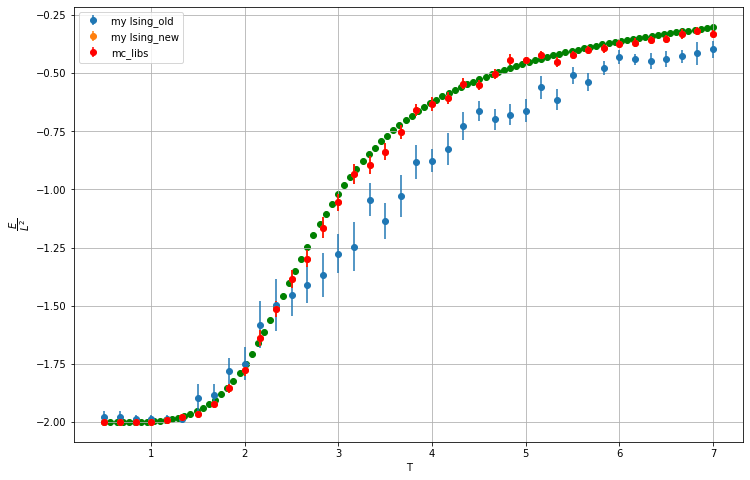

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(Temps, exact_energy / 16, color='green')
plt.errorbar(Temps1, mean_energis,errors,   marker = "o", linestyle="None", label='my Ising_old')
plt.errorbar(Temps1, mean_energis1,errors1,   marker = "o", linestyle="None", label='my Ising_new')
plt.errorbar(Temps1, mean_energis2,errors2,   marker = "o", color='red', linestyle="None", label='mc_libs' )
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\dfrac{E}{L^2}$")
plt.grid()

In [ ]:
mean_energis = []
mean_energis1 = []
mean_energis2 = []
errors = []
errors1 = []
errors2 = []
for t in Temps1:
    energs, mean_energ, error,converg, cf = IsingSimulate_old(4, t, 1000, 1,np.random.randint(0,1000))
    energs1, mean_energ1, error1,converg1, cf1 = IsingSimulate_new(4, t, 1000, 1,np.random.randint(0,1000))
    energs2, mean_energ2, error2,converg2, cf1 = simulate_ising(4, t, 1000, 1,np.random.randint(0,1000))
    mean_energis.append(mean_energ / 8)
    mean_energis1.append(mean_energ1 / 8)
    mean_energis2.append(mean_energ2 / 8)
    errors.append(error / 8)
    errors1.append(error1 / 8)
    errors2.append(error2 / 8)

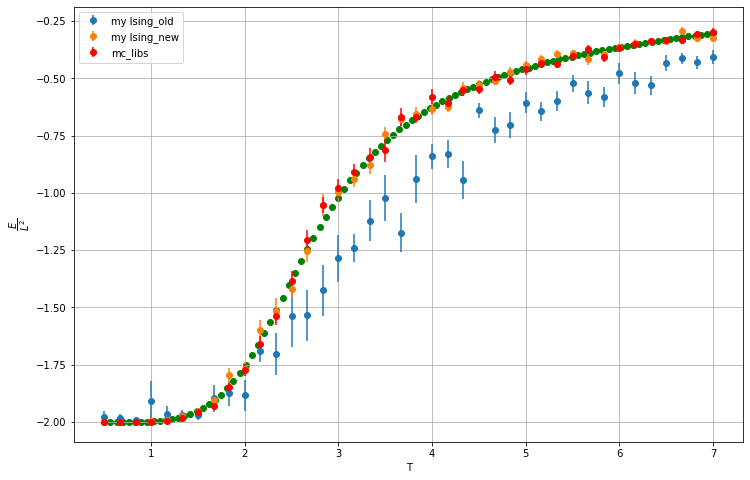

In [ ]:
plt.figure(figsize=(12,8))
plt.scatter(Temps, exact_energy / 16, color='green')
plt.errorbar(Temps1, mean_energis,errors,   marker = "o", linestyle="None", label='my Ising_old')
plt.errorbar(Temps1, mean_energis1,errors1,   marker = "o", linestyle="None", label='my Ising_new')
plt.errorbar(Temps1, mean_energis2,errors2,   marker = "o", color='red', linestyle="None", label='mc_libs' )
plt.legend()
plt.xlabel("T")
plt.ylabel(r"$\dfrac{E}{L^2}$")
plt.grid()